# School Safety - Part 2
### *Bullying Classification*

## 1. Background
The Department of Education conducts a periodic survey of public schools in the country: The School Survey on Crime and Safety (SSOCS). More information on this survey can be found [here](https://nces.ed.gov/surveys/ssocs/index.asp?FType=3). For this project, I downloaded cross-sectional data from the 2015-2016 school year. The relevant files are available directly in my GitHub repository, although they can also be manually downloaded from the National Center for Education Statistics (NCES) [website](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2018109). After some preliminary analysis, I chose to focus on three main questions:

1. Is it possible to predict how many violent incidents a school will have in a given year?
2. Is it possible to predict the extent to which bullying occurs at a school?
3. Is there discrimination based on race when it comes to disciplinary action at schools?

This notebook will focus on developing insights for the second question above.

**The analysis resulted in the following conclusions:**
1. The random forest model performed the best. 
2. More flexible models performed better than more standard models, suggesting some non-linearity/interaction between features.
3. The largest misclassifications were in predicting 4 instead of 3, 4 instead of 2, and 3 instead of 4. This suggests that the dominance of the majority class value 4 is making it difficult to accurately predict the minority classes.

## 2. Setup/Data Cleaning

The following [module](https://pypi.org/project/sas7bdat/) needs to be installed in order to read the original data file:

```pip install sas7bdat```

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sas7bdat import SAS7BDAT

%matplotlib inline

pd.options.display.max_columns = 17

In [3]:
reader = SAS7BDAT('school_safety.sas7bdat', skip_header=False)
school_df = reader.to_data_frame()
y_classification = school_df["C0376"]

From the below bar graph, it is evident that the target variable has an uneven class distribution. In order to ensure my ML algorithms were able to more accurately predict the underrepresented classes, I decided to incorporate oversampling on my training set. I also ensured my train and test set had equal proportions of each of the 5 categorical values and used stratified k-fold cross-validation.

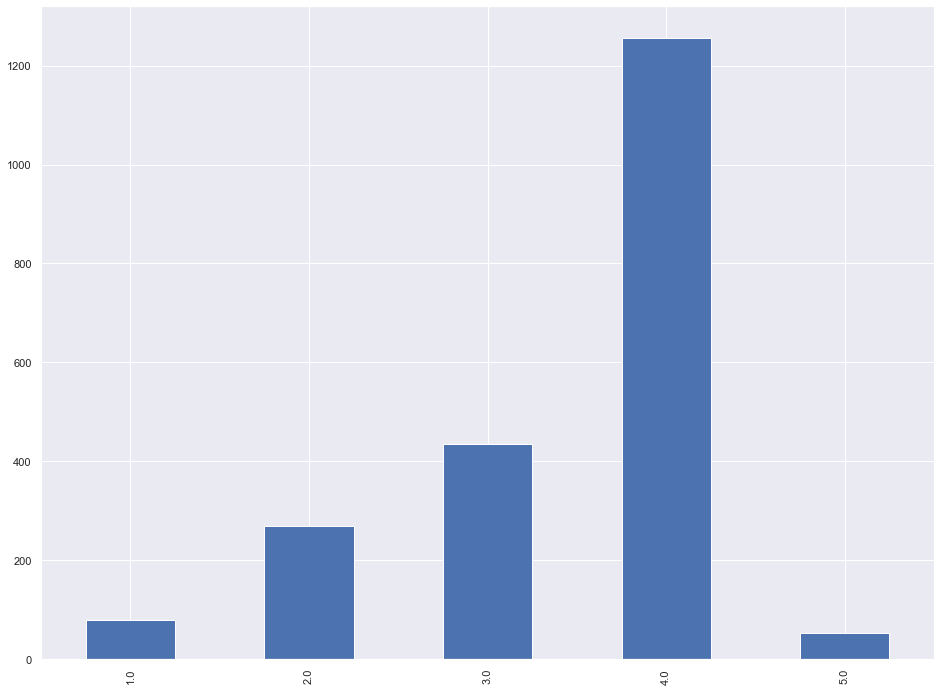

In [504]:
y_classification.value_counts().sort_index().plot.bar(figsize=(16,12))

In **School Safety - Part 1**, I removed any rows corresponding to target outliers (violent indicents > 31). Given that I used oversampling for this classification problem, it did not make sense to drop rows like before. I loaded the feature dataframe from Part 1, isolated the VIF reduced variable names, and re-filtered columns of the original school_df without dropping any rows.

In [48]:
#Load feature dataframe from "School Safety - Part 1"
feature_df_part_1 = pd.read_csv("feature_df_regression.csv", index_col = 0)
part_1_features = feature_df_part_1.columns
feature_df = school_df[part_1_features]

#Select binary columns
binary_cols = [col for col in feature_df.columns if feature_df[col].isin([1,2]).all()]
#Select non-binary columns
non_binary_cols = [col for col in feature_df.columns if not feature_df[col].isin([1,2]).all()]

In [49]:
#Convert non-binary categorical columns to custom values
#1 if city else 0
feature_df["FR_URBAN"] = feature_df["FR_URBAN"].apply(lambda x: 1 if x==1 else 0)
#1 if high school else 0
feature_df["FR_LVEL"] = feature_df["FR_LVEL"].apply(lambda x: 1 if x==3 else 0)
#1 if >=500 students else 0
feature_df["FR_SIZE"] = feature_df["FR_SIZE"].apply(lambda x: 1 if x in [3,4] else 0)

C:\Users\Sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [50]:
#Convert Y/N columns to 0 or 1
feature_df[binary_cols] = feature_df[binary_cols].applymap(lambda x: 1 if x==1 else 0)

C:\Users\Sahil\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [77]:
#I exported the final feature dataframe to a CSV file for easy access. File available in this repository.
feature_df = pd.read_csv("feature_df_classification.csv",index_col=0)
feature_df.head()

,C0114,C0116,C0120,C0121,C0122,C0124,C0126,C0128,...,C0526,C0528,C0532,SEC_FT16,SEC_PT16,FR_URBAN,FR_LVEL,FR_SIZE
0,1,0,0,0,0,0,0,0,...,2.0,17.0,30.0,0.0,0.0,0,0,0
1,1,0,0,1,1,0,0,0,...,25.0,2.0,0.0,0.0,0.0,0,0,0
2,1,0,0,1,1,0,0,0,...,5.0,9.0,18.0,0.0,1.0,0,0,0
3,1,0,0,0,1,0,0,0,...,61.0,9.0,15.0,0.0,0.0,0,0,0
4,1,0,0,1,1,0,0,0,...,35.0,8.0,40.0,1.0,0.0,0,0,0


In [78]:
#Recalculate binary vs non-binary columns
binary_cols = [col for col in feature_df.columns if feature_df[col].isin([0,1]).all()]
non_binary_cols = [col for col in feature_df.columns if not feature_df[col].isin([0,1]).all()]

## 3. Predictive Modeling
In this section, I trained several different machine learning models to see if the features from **School Safety - Part 1** could be used to make predictions about which category bullying fell into at US public school. I chose the weighted-F1 score as my primary metric for evaluating model performance.
### 3.1. Data Split, Scaling, and SMOTE-NC
I began by splitting my data into a train and test set, setting 20% of the entries aside as test data. In order to ensure I was able to make maximal use of my available data, I incorporated k-fold cross validation with 5 folds rather than setting aside another 20% of entries for a separate cross validation set. 

In [233]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_df, y_classification, 
                                                    test_size=0.2, random_state=5, 
                                                    stratify=y_classification)

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

Just like in Part 1, I had to standardize non-binary columns in order to ensure models would converge quickly and KNN would not be influenced by variable scale.

In [234]:
from sklearn.preprocessing import StandardScaler

#We will only scale non-binary columns
scaler = StandardScaler()

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled[non_binary_cols] = scaler.fit_transform(X_train[non_binary_cols])
col_mean = scaler.mean_
col_std = (scaler.var_)**.5

X_test_scaled[non_binary_cols] = (X_test[non_binary_cols]-col_mean)/col_std

C:\Users\Sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Sahil\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\Sahil\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Next, I used the synthetic minority oversampling technique (SMOTE) which required installation of the following [module](https://pypi.org/project/imbalanced-learn/):

```pip install imbalanced-learn```

This technique generates additional samples from the non-majority classes so that the resulting data set has an equal representation for all classes. These additional samples are not simply copies of existing rows. Instead, the algorithm utilizes a nearest neighbors approach to synthesize new data points. In this project, SMOTE drastically increases the number of rows in the training set.

A major challenge that arose was how to incorporate SMOTE into grid search and cross-fold validation. The synthetically generated training samples depend on the original training set. As a result, my decision to use 5 stratified folds essentially meant that 5 different SMOTE generated training sets would be needed. The below code solves this issue by generating a SMOTE training set for each of the 5 folds and saving the corresponding SMOTE training vs cross-validation indices into the **cv_indices** list.

In [358]:
from imblearn.over_sampling import SMOTENC

categorical_features = [True if col in binary_cols else False for col in X_train_scaled.columns]
sm = SMOTENC(categorical_features=categorical_features, random_state= 7)

X_train_custom = X_train_scaled.reset_index(drop=True)
y_train_custom = y_train.reset_index(drop=True)
num_rows_original = X_train_custom.shape[0]

smote_indices = []
cv_indices = []

fold_num=0
for train_index, cv_index in kf.split(X_train_custom,y_train_custom):
    num_rows_fold_original = len(train_index)
    X_train_smote_fold, y_train_smote_fold = sm.fit_sample(X_train_custom.iloc[train_index], 
                                                           y_train_custom.iloc[train_index])
    X_train_smote_fold = X_train_smote_fold.iloc[num_rows_fold_original:]
    y_train_smote_fold = y_train_smote_fold.iloc[num_rows_fold_original:]
    X_train_custom = pd.concat([X_train_custom,X_train_smote_fold],ignore_index=True)
    y_train_custom = pd.concat([y_train_custom,y_train_smote_fold],ignore_index=True)
    if fold_num==0:
        smote_indices.append([*range(num_rows_original,num_rows_original+X_train_smote_fold.shape[0])])
    else:
        last_row = smote_indices[-1][-1]
        smote_indices.append([*range(last_row+1,last_row+1+X_train_smote_fold.shape[0])])
    
    
    train_index_fold = np.append(train_index,smote_indices[fold_num])
    cv_index_fold = cv_index
    cv_indices.append((train_index_fold,cv_index_fold)) 
    
    fold_num+=1

Finally, I ran SMOTE on the entire training set (without leaving any data out for cross-validation).

In [442]:
X_train_smote, y_train_smote = sm.fit_sample(X_train_scaled, y_train)
y_train_smote.value_counts()

### 3.2. Logistic Regression
The following models incorporate variations of logistic regression. First, I ran a standard logistic regression on the entire feature set. In order to address overfitting, I next constructed a recursive feature elimination regression.
#### 3.2.1. Standard Logistic Regression

In [436]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_params = {"penalty":["l1","l2"], 
              "C":[.0001,.001,.01,.1,1,10,100,1000,3333,10000,33333,100000], 
              "random_state":[20],
              "solver":["liblinear"], 
              "max_iter":[1000]}
log = LogisticRegression()
log_grid = GridSearchCV(estimator=log,
                        param_grid=log_params,
                        scoring="f1_weighted",
                        cv=cv_indices)
log_grid.fit(X_train_custom, y_train_custom)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.003, total=   0.0s
[CV] C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.003, total=   0.1s
[CV] C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.003, total=   0.0s
[CV] C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.002, total=   0.0s
[CV] C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.0001, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.002, total=   0.0s
[CV] C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear 
[CV]  C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear, score=0.046, total=   0.1s
[CV] C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear 
[CV]  C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear, score=0.089, total=   0.0s
[CV] C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear 
[CV]  C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear, score=0.104, total=   0.1s
[CV] C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear 
[CV]  C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear, score=0.072, total=   0.1s
[CV] C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear 
[CV]  C=0.0001, max_iter=1000, penalty=l2, random_state=20, solver=liblinear, score=0.109,

[CV]  C=10, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.446, total=   0.6s
[CV] C=10, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=10, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.422, total=   0.7s
[CV] C=10, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=10, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.483, total=   0.7s
[CV] C=10, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=10, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.412, total=   0.9s
[CV] C=10, max_iter=1000, penalty=l2, random_state=20, solver=liblinear 
[CV]  C=10, max_iter=1000, penalty=l2, random_state=20, solver=liblinear, score=0.414, total=   0.2s
[CV] C=10, max_iter=1000, penalty=l2, random_state=20, solver=liblinear 
[CV]  C=10, max_iter=1000, penalty=l2, random_state=20, solver=liblinear, score=0.446, total=   0.2s
[CV] C=10, max_iter=1000, pen

[CV]  C=10000, max_iter=1000, penalty=l2, random_state=20, solver=liblinear, score=0.412, total=   0.2s
[CV] C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.420, total=   0.7s
[CV] C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.448, total=   0.6s
[CV] C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.420, total=   0.6s
[CV] C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.479, total=   0.7s
[CV] C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear 
[CV]  C=33333, max_iter=1000, penalty=l1, random_state=20, solver=liblinear, score=0.412, total=   0

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   42.0s finished


GridSearchCV(cv=[(array([   0,    1,    2, ..., 4352, 4353, 4354]),
                  array([  16,   18,   28,   30,   35,   41,   45,   46,   55,   74,   75,
         78,   83,   84,   88,   90,  109,  110,  111,  113,  115,  117,
        119,  125,  126,  134,  144,  145,  150,  154,  157,  163,  165,
        166,  178,  180,  184,  187,  189,  195,  199,  204,  206,  209,
        210,  212,  220,  224,  225,  226,  227,  234,  240,  244,  248,
        257,  261,  268,  269,  281,  293,  294,  300,  304,  306,  307,
        310,  317,  327,  329,  344,  350,  351,  356,  361,  375,  380...
       1543, 1546, 1552, 1564, 1567, 1571, 1578, 1582, 1584, 1586, 1591,
       1593, 1598, 1606, 1614, 1620, 1625, 1635, 1642, 1655, 1656, 1659,
       1662, 1667, 1668, 1671]))],
             estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 3333,
                               10000, 33333, 100000],
                         'max_iter': [10

In [437]:
log_grid.best_params_

{'C': 10,
 'max_iter': 1000,
 'penalty': 'l1',
 'random_state': 20,
 'solver': 'liblinear'}

In [438]:
log_grid.best_score_

0.43650983991224823

In [445]:
log = log_grid.best_estimator_
log.fit(X_train_smote,y_train_smote)

LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=20,
                   solver='liblinear')

In [474]:
log_coef = pd.DataFrame(log.coef_)
log_coef.columns = X_train_smote.columns
log_features = log_coef.columns[log_coef.mean()!=0]
len(log_features)

73

#### 3.2.2. Logistic Regression with Recursive Feature Elimination

In [419]:
from sklearn.feature_selection import RFECV

rfe_df = pd.DataFrame()

for C in [.0001,.001,.01,.1,1,10,100,1000,3333,10000,33333,100000]:
    for penalty in ["l1","l2"]:
        log_rfe = LogisticRegression(C=C,penalty=penalty,max_iter=5000,random_state=20,solver="liblinear")
        selector = RFECV(log_rfe, cv=cv_indices, scoring="f1_weighted")
        selector.fit(X_train_custom, y_train_custom)
        n_features = selector.n_features_
        features = selector.support_
        best_score = max(selector.grid_scores_)
        rfe_df = rfe_df.append({"C":C,"penalty":penalty,"n_features":n_features,
                                "features":features,"best_score":best_score},ignore_index=True)

0.0001
0.001
0.01
0.1
1
10
100
1000
3333
10000
33333
100000


In [422]:
rfe_df.sort_values(by="best_score",ascending=False)

,C,best_score,features,n_features,penalty
8,1.0000,0.438245,"[True, False, True, False, True, True, True, T...",66.0,l1
10,10.0000,0.438175,"[True, True, True, False, True, True, True, Tr...",69.0,l1
15,1000.0000,0.437870,"[True, True, True, False, True, True, True, Tr...",68.0,l2
11,10.0000,0.437809,"[True, True, True, True, True, True, True, Tru...",70.0,l2
23,100000.0000,0.437417,"[True, True, True, False, True, True, True, Tr...",68.0,l2
21,33333.0000,0.437417,"[True, True, True, False, True, True, True, Tr...",68.0,l2
19,10000.0000,0.437417,"[True, True, True, False, True, True, True, Tr...",68.0,l2
17,3333.0000,0.437417,"[True, True, True, False, True, True, True, Tr...",68.0,l2
14,1000.0000,0.437285,"[True, True, True, True, True, True, True, Tru...",70.0,l1
22,100000.0000,0.437285,"[True, True, True, True, True, True, True, Tru...",70.0,l1


In [462]:
rfe_features = rfe_df.loc[8,"features"]
log_rfe = LogisticRegression(C=1,penalty="l1",max_iter=5000,random_state=20,solver="liblinear")
log_rfe.fit(X_train_smote.loc[:,rfe_features],y_train_smote)

LogisticRegression(C=1, max_iter=5000, penalty='l1', random_state=20,
                   solver='liblinear')

In [464]:
log_rfe_coef = pd.DataFrame(log_rfe.coef_)
log_rfe_coef.columns = X_train_smote.loc[:,rfe_features].columns
log_rfe_features = log_rfe_coef.columns[log_rfe_coef.mean()!=0]
len(log_rfe_features)

66

### 3.3. K-Nearest Neighbors
While the above logistic regressions were quite promising, I wanted to see if other ML models would result in better performance. I next built a KNN model on the standard logistic regression feature set and the RFE selected feature set. 
#### 3.3.1. KNN on Standard Feature Set

In [475]:
from sklearn.neighbors import KNeighborsClassifier
knn_params = {"n_neighbors" : [2,4,8,16,32,64,128,256,512],
              "weights" : ["uniform", "distance"],
              "p" : [1,2]}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(estimator=knn,
                        param_grid=knn_params,
                        scoring="f1_weighted",
                        cv=cv_indices)
knn_grid.fit(X_train_custom[log_features], y_train_custom)

GridSearchCV(cv=[(array([   0,    1,    2, ..., 4352, 4353, 4354]),
                  array([  16,   18,   28,   30,   35,   41,   45,   46,   55,   74,   75,
         78,   83,   84,   88,   90,  109,  110,  111,  113,  115,  117,
        119,  125,  126,  134,  144,  145,  150,  154,  157,  163,  165,
        166,  178,  180,  184,  187,  189,  195,  199,  204,  206,  209,
        210,  212,  220,  224,  225,  226,  227,  234,  240,  244,  248,
        257,  261,  268,  269,  281,  293,  294,  300,  304,  306,  307,
        310,  317,  327,  329,  344,  350,  351,  356,  361,  375,  380...
       1407, 1416, 1442, 1445, 1447, 1449, 1453, 1468, 1470, 1475, 1486,
       1489, 1490, 1497, 1501, 1506, 1527, 1531, 1533, 1535, 1540, 1541,
       1543, 1546, 1552, 1564, 1567, 1571, 1578, 1582, 1584, 1586, 1591,
       1593, 1598, 1606, 1614, 1620, 1625, 1635, 1642, 1655, 1656, 1659,
       1662, 1667, 1668, 1671]))],
             estimator=KNeighborsClassifier(),
             param_grid={'n

In [476]:
knn_grid.best_params_

{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}

In [477]:
knn_grid.best_score_

0.3486041126060394

#### 3.3.2. KNN on RFE Feature Set

In [470]:
knn_rfe_grid = GridSearchCV(estimator=knn,
                            param_grid=knn_params,
                            scoring="f1_weighted",
                            cv=cv_indices)
knn_rfe_grid.fit(X_train_custom.loc[:,rfe_features], y_train_custom)

GridSearchCV(cv=[(array([   0,    1,    2, ..., 4352, 4353, 4354]),
                  array([  16,   18,   28,   30,   35,   41,   45,   46,   55,   74,   75,
         78,   83,   84,   88,   90,  109,  110,  111,  113,  115,  117,
        119,  125,  126,  134,  144,  145,  150,  154,  157,  163,  165,
        166,  178,  180,  184,  187,  189,  195,  199,  204,  206,  209,
        210,  212,  220,  224,  225,  226,  227,  234,  240,  244,  248,
        257,  261,  268,  269,  281,  293,  294,  300,  304,  306,  307,
        310,  317,  327,  329,  344,  350,  351,  356,  361,  375,  380...
       1407, 1416, 1442, 1445, 1447, 1449, 1453, 1468, 1470, 1475, 1486,
       1489, 1490, 1497, 1501, 1506, 1527, 1531, 1533, 1535, 1540, 1541,
       1543, 1546, 1552, 1564, 1567, 1571, 1578, 1582, 1584, 1586, 1591,
       1593, 1598, 1606, 1614, 1620, 1625, 1635, 1642, 1655, 1656, 1659,
       1662, 1667, 1668, 1671]))],
             estimator=KNeighborsClassifier(),
             param_grid={'n

In [471]:
knn_rfe_grid.best_params_

{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

In [472]:
knn_rfe_grid.best_score_

0.368056486653054

### 3.4. Support Vector Machine

In [478]:
from sklearn.svm import SVC
svm_params = {"C":[.0001,.001,.01,.1,1,10,100,1000], 
              "kernel":["poly","rbf"],
              "degree":[2,3]}
svm = SVC()
svm_grid = GridSearchCV(estimator=svm,
                        param_grid=svm_params,
                        scoring="f1_weighted",
                        cv=cv_indices, 
                        verbose=3)
svm_grid.fit(X_train_custom, y_train_custom)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=0.0001, degree=2, kernel=poly .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.025, total=   2.1s
[CV] C=0.0001, degree=2, kernel=poly .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.029, total=   2.1s
[CV] C=0.0001, degree=2, kernel=poly .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.004, total=   2.0s
[CV] C=0.0001, degree=2, kernel=poly .................................
[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.057, total=   1.9s
[CV] C=0.0001, degree=2, kernel=poly .................................
[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.068, total=   2.0s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] ...... C=0.0001, degree=2, kernel=rbf, score=0.455, total=   3.0s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] ...... C=0.0001, degree=2, kernel=rbf, score=0.438, total=   3.2s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] ...... C=0.0001, degree=2, kernel=rbf, score=0.460, total=   3.4s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] ...... C=0.0001, degree=2, kernel=rbf, score=0.459, total=   3.1s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] .

[CV] ........ C=0.1, degree=2, kernel=poly, score=0.466, total=   1.0s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV] ........ C=0.1, degree=2, kernel=poly, score=0.474, total=   1.2s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV] ........ C=0.1, degree=2, kernel=poly, score=0.454, total=   1.1s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV] ........ C=0.1, degree=2, kernel=poly, score=0.494, total=   1.0s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV] ........ C=0.1, degree=2, kernel=poly, score=0.453, total=   1.2s
[CV] C=0.1, degree=2, kernel=rbf .....................................
[CV] ......... C=0.1, degree=2, kernel=rbf, score=0.481, total=   2.0s
[CV] C=0.1, degree=2, kernel=rbf .....................................
[CV] ......... C=0.1, degree=2, kernel=rbf, score=0.477, total=   1.9s
[CV] C=0.1, degree=2, kernel=rbf .....................................
[CV] .

[CV] .......... C=10, degree=3, kernel=rbf, score=0.535, total=   1.1s
[CV] C=10, degree=3, kernel=rbf ......................................
[CV] .......... C=10, degree=3, kernel=rbf, score=0.447, total=   1.2s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.447, total=   1.0s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.448, total=   1.0s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.432, total=   1.0s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.492, total=   1.0s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.453, total=   0.9s
[CV] C=100, degree=2, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  4.4min finished


GridSearchCV(cv=[(array([   0,    1,    2, ..., 4352, 4353, 4354]),
                  array([  16,   18,   28,   30,   35,   41,   45,   46,   55,   74,   75,
         78,   83,   84,   88,   90,  109,  110,  111,  113,  115,  117,
        119,  125,  126,  134,  144,  145,  150,  154,  157,  163,  165,
        166,  178,  180,  184,  187,  189,  195,  199,  204,  206,  209,
        210,  212,  220,  224,  225,  226,  227,  234,  240,  244,  248,
        257,  261,  268,  269,  281,  293,  294,  300,  304,  306,  307,
        310,  317,  327,  329,  344,  350,  351,  356,  361,  375,  380...
       1407, 1416, 1442, 1445, 1447, 1449, 1453, 1468, 1470, 1475, 1486,
       1489, 1490, 1497, 1501, 1506, 1527, 1531, 1533, 1535, 1540, 1541,
       1543, 1546, 1552, 1564, 1567, 1571, 1578, 1582, 1584, 1586, 1591,
       1593, 1598, 1606, 1614, 1620, 1625, 1635, 1642, 1655, 1656, 1659,
       1662, 1667, 1668, 1671]))],
             estimator=SVC(),
             param_grid={'C': [0.0001, 0.001

In [479]:
svm_grid.best_params_

{'C': 0.1, 'degree': 2, 'kernel': 'rbf'}

In [480]:
svm_grid.best_score_

0.48239154577478277

### 3.5. Random Forest

In [499]:
from sklearn.ensemble import RandomForestClassifier
rf_params = {"n_estimators" : [300], 
             "max_depth" : [2,4,8,16,32,64,128,None], 
             "max_features" : ["sqrt", "log2", .1, .25, .5, 5, 10, 25], 
             "min_samples_leaf" : [1,3,5],
             "random_state" : [10]}
rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf,
                       param_grid=rf_params,
                       scoring="f1_weighted",
                       cv=cv_indices)
rf_grid.fit(X_train_custom, y_train_custom)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.196, total=   0.8s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.205, total=   0.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.227, total=   0.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.243, total=   0.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.211, total=   0.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.196, total=   0.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.205, total=   0.8s
[CV] max_depth=2, max_features=s

[CV]  max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.214, total=   0.7s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.231, total=   0.7s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.199, total=   0.6s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.192, total=   0.6s
[CV] max_depth=2, max_features=0.25, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=0.25, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.158, total=   0.9s
[CV] max_depth=2, max_features=0.25, mi

[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.224, total=   0.6s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.225, total=   0.6s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.264, total=   0.6s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.239, total=   0.5s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.224, total=   0.5s
[CV] max_depth=2, max_features=5, min_samples_leaf=5, n_est

[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.354, total=   1.0s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.358, total=   1.0s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.396, total=   0.8s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.390, total=   0.9s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.370, total=   0.8s
[CV] max_depth=4, max_features=s

[CV]  max_depth=4, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.370, total=   0.8s
[CV] max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.358, total=   0.8s
[CV] max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.378, total=   0.8s
[CV] max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.382, total=   0.9s
[CV] max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.385, total=   0.9s
[CV] max_depth=4, max_features=0.1, min_s

[CV]  max_depth=4, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.400, total=   0.7s
[CV] max_depth=4, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.374, total=   0.8s
[CV] max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.383, total=   0.7s
[CV] max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.377, total=   0.7s
[CV] max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.400, total=   0.7s
[CV] max_depth=4, max_features=5, min_samples_leaf=3, n_est

[CV]  max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.387, total=   1.5s
[CV] max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.312, total=   1.8s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.461, total=   1.5s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.490, total=   1.6s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.496, total=   1.4s
[CV] max_depth=8, max_features=sqrt, m

[CV]  max_depth=8, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.487, total=   1.4s
[CV] max_depth=8, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.494, total=   1.3s
[CV] max_depth=8, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.444, total=   1.6s
[CV] max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.452, total=   1.6s
[CV] max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.484, total=   1.7s
[CV] max_depth=8, max_features=0.1, min_s

[CV]  max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.478, total=   1.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.473, total=   1.1s
[CV] max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.490, total=   1.0s
[CV] max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.445, total=   1.2s
[CV] max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.463, total=   1.0s
[CV] max_depth=8, max_features=5, min_samples_leaf=3, n_est

[CV]  max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.443, total=   2.6s
[CV] max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.466, total=   2.9s
[CV] max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.491, total=   2.6s
[CV] max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.472, total=   2.6s
[CV] max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.473, total=   1.9s
[CV] max_depth=16, max_features=sqrt, min_sa

[CV]  max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.469, total=   1.4s
[CV] max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.490, total=   1.6s
[CV] max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.480, total=   1.6s
[CV] max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.496, total=   2.1s
[CV] max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.449, total=   2.0s
[CV] max_depth=16, max_features=

[CV]  max_depth=16, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.471, total=   4.5s
[CV] max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.476, total=   1.6s
[CV] max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.487, total=   1.7s
[CV] max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.472, total=   1.6s
[CV] max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.483, total=   1.6s
[CV] max_depth=16, max_features=5, min_samples_l

[CV]  max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.468, total=   3.3s
[CV] max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.472, total=   3.0s
[CV] max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.453, total=   3.3s
[CV] max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.495, total=   3.4s
[CV] max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.495, total=   3.3s
[CV] max_depth=16, max_features=25, min_s

[CV]  max_depth=32, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.500, total=   1.7s
[CV] max_depth=32, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.465, total=   1.8s
[CV] max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.469, total=   1.5s
[CV] max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.502, total=   1.4s
[CV] max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.474, total=   1.6s
[CV] max_depth=32, max_features=

[CV]  max_depth=32, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.481, total=   3.9s
[CV] max_depth=32, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.495, total=   4.2s
[CV] max_depth=32, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.477, total=   4.4s
[CV] max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.464, total=   1.5s
[CV] max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.470, total=   1.8s
[CV] max_depth=32, max_features=5, min_s

[CV]  max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.476, total=   3.2s
[CV] max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.517, total=   3.6s
[CV] max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.461, total=   3.5s
[CV] max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.474, total=   2.8s
[CV] max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.465, total=   2.8s
[CV] max_depth=32, max_features=25, min_s

[CV]  max_depth=64, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.482, total=   1.6s
[CV] max_depth=64, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.483, total=   1.7s
[CV] max_depth=64, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.500, total=   1.6s
[CV] max_depth=64, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.465, total=   1.8s
[CV] max_depth=64, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=0.1, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.469, total=   1.7s
[CV] max_depth=64, max_features=

[CV]  max_depth=64, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.452, total=   4.3s
[CV] max_depth=64, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.461, total=   4.2s
[CV] max_depth=64, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.481, total=   4.0s
[CV] max_depth=64, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.495, total=   4.1s
[CV] max_depth=64, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.477, total=   4.6s
[CV] max_depth=64, max_features=

[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.460, total=   3.2s
[CV] max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.467, total=   3.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.476, total=   3.0s
[CV] max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.517, total=   3.2s
[CV] max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.461, total=   3.1s
[CV] max_depth=64, max_features=25, min_s

[CV]  max_depth=128, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.458, total=   1.3s
[CV] max_depth=128, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.484, total=   1.6s
[CV] max_depth=128, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.482, total=   1.5s
[CV] max_depth=128, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.483, total=   1.6s
[CV] max_depth=128, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=0.1, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.500, total=   1.5s
[CV] max_depth=128, ma

[CV]  max_depth=128, max_features=0.5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.481, total=   5.4s
[CV] max_depth=128, max_features=0.5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=0.5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.475, total=   5.0s
[CV] max_depth=128, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.452, total=   5.1s
[CV] max_depth=128, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.461, total=   4.7s
[CV] max_depth=128, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=0.5, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.481, total=   4.6s
[CV] max_depth=128, max

[CV]  max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.490, total=   3.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.500, total=   3.6s
[CV] max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.460, total=   4.3s
[CV] max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.460, total=   4.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.467, total=   3.2s
[CV] max_depth=128, max_features

[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.454, total=   1.4s
[CV] max_depth=None, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.470, total=   1.2s
[CV] max_depth=None, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.514, total=   1.2s
[CV] max_depth=None, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.493, total=   1.2s
[CV] max_depth=None, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.458, total=   1.2s
[CV] 

[CV]  max_depth=None, max_features=0.5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.503, total=   5.4s
[CV] max_depth=None, max_features=0.5, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=0.5, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.459, total=   4.8s
[CV] max_depth=None, max_features=0.5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=0.5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.453, total=   4.4s
[CV] max_depth=None, max_features=0.5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=0.5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.461, total=   4.4s
[CV] max_depth=None, max_features=0.5, min_samples_leaf=3, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=0.5, min_samples_leaf=3, n_estimators=300, random_state=10, score=0.480, total=   4.0s
[CV] max_depth

[CV]  max_depth=None, max_features=10, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.489, total=   1.6s
[CV] max_depth=None, max_features=10, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=10, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.496, total=   1.6s
[CV] max_depth=None, max_features=10, min_samples_leaf=5, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=10, min_samples_leaf=5, n_estimators=300, random_state=10, score=0.458, total=   1.8s
[CV] max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.472, total=   3.7s
[CV] max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=300, random_state=10 
[CV]  max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=300, random_state=10, score=0.484, total=   3.4s
[CV] max_depth=None, ma

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 32.0min finished


GridSearchCV(cv=[(array([   0,    1,    2, ..., 4352, 4353, 4354]),
                  array([  16,   18,   28,   30,   35,   41,   45,   46,   55,   74,   75,
         78,   83,   84,   88,   90,  109,  110,  111,  113,  115,  117,
        119,  125,  126,  134,  144,  145,  150,  154,  157,  163,  165,
        166,  178,  180,  184,  187,  189,  195,  199,  204,  206,  209,
        210,  212,  220,  224,  225,  226,  227,  234,  240,  244,  248,
        257,  261,  268,  269,  281,  293,  294,  300,  304,  306,  307,
        310,  317,  327,  329,  344,  350,  351,  356,  361,  375,  380...
       1543, 1546, 1552, 1564, 1567, 1571, 1578, 1582, 1584, 1586, 1591,
       1593, 1598, 1606, 1614, 1620, 1625, 1635, 1642, 1655, 1656, 1659,
       1662, 1667, 1668, 1671]))],
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, None],
                         'max_features': ['sqrt', 'log2', 0.1, 0.25, 0.5, 5, 10,
                  

In [500]:
rf_grid.best_params_

{'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 300,
 'random_state': 10}

In [501]:
rf_grid.best_score_

0.49108422293523885

### 3.6. Neural Network
Given the computational requirements of multi-layer neural networks, the following block of code took quite some time to run.

In [484]:
from sklearn.neural_network import MLPClassifier
nn_params = {"hidden_layer_sizes" : [(100,),(100,100)], 
             "activation" : ["logistic", "tanh", "relu"], 
             "alpha" : [.00001,.0001,.001,.01,.1,1.0,10,100,1000],
             "max_iter" : [2500],
             "random_state" : [10], 
             "warm_start" : [True]}
nn = MLPClassifier()
nn_grid = GridSearchCV(estimator=nn,
                       param_grid=nn_params,
                       scoring="f1_weighted",
                       cv=cv_indices)
nn_grid.fit(X_train_custom, y_train_custom)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.454, total=  24.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.6s remaining:    0.0s


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.449, total=  24.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.2s remaining:    0.0s


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.449, total=  23.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.488, total=  22.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.398, total=  22.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.464, total=  29.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(100, 100), max_i

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.428, total=  26.4s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.472, total=  31.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.439, total=  35.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.448, total=  35.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 100

[CV]  activation=logistic, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.072, total=   2.8s
[CV] activation=logistic, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.029, total=   3.9s
[CV] activation=logistic, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.029, total=   4.1s
[CV] activation=logistic, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.028, total=   3.1s
[CV] activation=logistic, alpha=100, hidden_layer_sizes=(100,), max_iter=250

[CV]  activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.456, total=  10.5s
[CV] activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.420, total=  11.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.464, total=  11.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.452, total=  11.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, 

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.440, total=  11.8s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.451, total=  11.9s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.490, total=  12.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.430, total=  12.4s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activa

[CV]  activation=tanh, alpha=100, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.002, total=   1.6s
[CV] activation=tanh, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.001, total=   2.1s
[CV] activation=tanh, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.450, total=   2.1s
[CV] activation=tanh, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.450, total=   1.9s
[CV] activation=tanh, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.435, total=   7.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.456, total=   7.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.442, total=   7.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.429, total=  10.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(100,), max_iter=2500, random_st

[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.446, total=   6.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.484, total=   4.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.442, total=   5.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.475, total=   5.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation

[CV]  activation=relu, alpha=1000, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.002, total=   1.7s
[CV] activation=relu, alpha=1000, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=1000, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, score=0.452, total=   1.7s
[CV] activation=relu, alpha=1000, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=1000, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.029, total=   3.0s
[CV] activation=relu, alpha=1000, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=1000, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, score=0.029, total=   2.9s
[CV] activation=relu, alpha=1000, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 46.9min finished


GridSearchCV(cv=[(array([   0,    1,    2, ..., 4352, 4353, 4354]),
                  array([  16,   18,   28,   30,   35,   41,   45,   46,   55,   74,   75,
         78,   83,   84,   88,   90,  109,  110,  111,  113,  115,  117,
        119,  125,  126,  134,  144,  145,  150,  154,  157,  163,  165,
        166,  178,  180,  184,  187,  189,  195,  199,  204,  206,  209,
        210,  212,  220,  224,  225,  226,  227,  234,  240,  244,  248,
        257,  261,  268,  269,  281,  293,  294,  300,  304,  306,  307,
        310,  317,  327,  329,  344,  350,  351,  356,  361,  375,  380...
       1543, 1546, 1552, 1564, 1567, 1571, 1578, 1582, 1584, 1586, 1591,
       1593, 1598, 1606, 1614, 1620, 1625, 1635, 1642, 1655, 1656, 1659,
       1662, 1667, 1668, 1671]))],
             estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10,
                                  

In [485]:
nn_grid.best_params_

{'activation': 'tanh',
 'alpha': 1e-05,
 'hidden_layer_sizes': (100,),
 'max_iter': 2500,
 'random_state': 10,
 'warm_start': True}

In [486]:
nn_grid.best_score_

0.46628367832376244

### 3.7. Model Selection and Interpretation

The results of the above models are summarized in the table below (ordered from best to worst performance):

In [503]:
models = ["Logistic Regression - Standard", 
          "Logistic Regression - RFE", 
          "K-Nearest Neighbors - Standard",
          "K-Nearest Neighbors - RFE", 
          "Support Vector Machine",
          "Random Forest", 
          "Neural Network"]

optimized_parameters = [log_grid.best_params_, 
                        {'n_features':66,'C':1,'max_iter':1000,'penalty':'l1','random_state':20,'solver':'liblinear'}, 
                        knn_grid.best_params_, 
                        knn_rfe_grid.best_params_, 
                        svm_grid.best_params_,
                        rf_grid.best_params_, 
                        nn_grid.best_params_]

F1 = [log_grid.best_score_,
      0.438245, 
      knn_grid.best_score_,
      knn_rfe_grid.best_score_,
      svm_grid.best_score_,
      rf_grid.best_score_,
      nn_grid.best_score_]
       
model_df = pd.DataFrame({"model" : models, 
                         "optimized_parameters" : optimized_parameters, 
                         "weighted-F1" : F1})

with pd.option_context('display.max_colwidth', 150):
    display(model_df.sort_values(by="weighted-F1",ascending=False))

,model,optimized_parameters,weighted-F1
5,Random Forest,"{'max_depth': 32, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 10}",0.491084
4,Support Vector Machine,"{'C': 0.1, 'degree': 2, 'kernel': 'rbf'}",0.482392
6,Neural Network,"{'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'max_iter': 2500, 'random_state': 10, 'warm_start': True}",0.466284
1,Logistic Regression - RFE,"{'n_features': 66, 'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'random_state': 20, 'solver': 'liblinear'}",0.438245
0,Logistic Regression - Standard,"{'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'random_state': 20, 'solver': 'liblinear'}",0.436510
3,K-Nearest Neighbors - RFE,"{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}",0.368056
2,K-Nearest Neighbors - Standard,"{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}",0.348604


The random forest model performed the best. More flexible models performed better than more standard models, suggesting some non-linearity/interaction between features. I ran the random forest model with the optimized parameters on the test set for a final assessment of weighted-F1.

In [577]:
#Fit model to entire SMOTE training set
model_best = RandomForestClassifier(max_depth=32,max_features="sqrt",n_estimators=300,random_state=10)
model_best.fit(X_train_smote,y_train_smote)

#Predict test values
y_pred = model_best.predict(X_test)

#Calculate weighted-F1
from sklearn.metrics import f1_score
f1_score(y_test,y_pred,average="weighted")

0.46170242918007665

Next, I built a confusion matrix. The model never correctly predicted values of 1 or 5. The largest misclassifications were in predicting 4 instead of 3, 4 instead of 2, and 3 instead of 4. This suggests that even with SMOTE-NC, the dominance of the majority class value 4 is making it difficult to accurately predict the minority classes.

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5')]

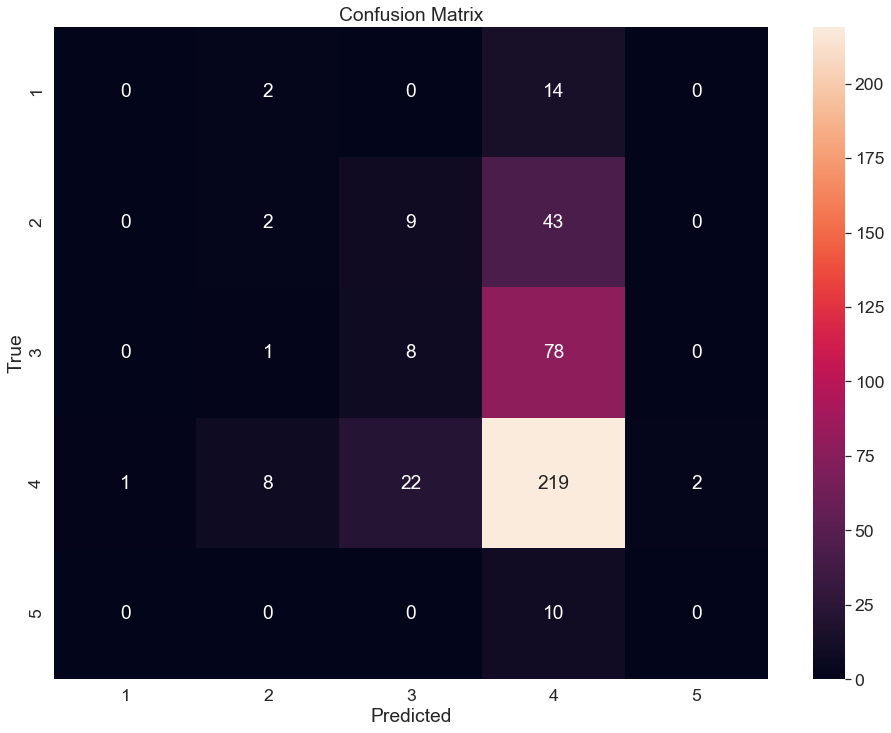

In [589]:
from sklearn.metrics import confusion_matrix
sns.set(font_scale=1.6)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(cm, annot=True, ax = ax, fmt="d")
ax.set_xlabel('Predicted')
ax.set_ylabel('True') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([1,2,3,4,5])
ax.yaxis.set_ticklabels([1,2,3,4,5])

For the random morest model, interpretation of which variables affect bullying classification is not immediately obvious. Fortunately, there is a [package](https://pypi.org/project/treeinterpreter/) that addresses this issue:

```pip install treeinterpreter```
 
For each test row, this module splits the classification probabilities into a bias and feature contribution array. The predicted probability for each class is **(bias array) + (feature_contribution array * feature value)**. 

I also copied over the variable name lookup function from Part 1 to assist with the following analysis.

In [547]:
cols_to_keep_df = pd.read_csv("column_filter.csv")

def col_description_lookup(col_list):
    result = pd.DataFrame({"Variable" : col_list})
    result = result.merge(cols_to_keep_df[["Variable", "Label"]], how="left", on="Variable")
    return result

In [506]:
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(model_best, X_test)
contributions_df = pd.DataFrame(contributions.mean(axis=0))
contributions_df = contributions_df.set_index(X_test.columns)
contributions_df.columns = [1,2,3,4,5]

In [600]:
for label, contribution in contributions_df.items():
    biggest_contribution = contribution.sort_values().iloc[[0,1,2,3,4,-5,-4,-3,-2,-1]]
    with pd.option_context('display.max_colwidth',150):
        result = col_description_lookup(biggest_contribution.index)
        result['Mean_Contribution'] = biggest_contribution.values
        result = result.style.set_caption("Top Contributions to Predicting "+str(label))
        display(result)

,Variable,Label,Mean_Contribution
0,C0153,Prohibit use of cell phones and text messaging devices,-0.013496
1,C0442,School probation available,-0.007659
2,C0143,Provide a structured anonymous threat reporting system,-0.006560
3,C0394,Removal with tutoring/at-home instruction available,-0.006201
4,C0124,Practice random dog sniffs for drugs,-0.005823
5,C0140,Require clear book bags or ban book bags,-0.000143
6,C0134,Require students to wear uniforms,-0.000129
7,C0438,Corporal punishment available,-0.000106
8,C0116,Students pass through metal detectors,-0.000028
9,FR_LVEL,Grade Level of school,0.000000


,Variable,Label,Mean_Contribution
0,FR_SIZE,Size of school,-0.003814
1,SEC_FT16,"Total # of full-time security guards, SROs, or sworn law enforcement officers",-0.002582
2,C0532,Percent students below 15th percentile standardized tests,-0.001903
3,C0526,Percent students limited English proficient,-0.001878
4,C0528,Percent special education students,-0.001864
5,C0180,Individual mentoring/tutoring by students,0.001015
6,C0426,In-school disciplinary plan available,0.001137
7,C0274,Teacher training - student alcohol/drug abuse,0.001519
8,C0124,Practice random dog sniffs for drugs,0.001655
9,C0153,Prohibit use of cell phones and text messaging devices,0.004649


,Variable,Label,Mean_Contribution
0,C0122,Practice to close campus for lunch,-0.000640
1,C0142,Require students to wear badge or photo ID,-0.000391
2,C0167,Drilled students on plan for shelter-in-place,-0.000347
3,C0134,Require students to wear uniforms,-0.000321
4,C0128,Require drug testing for athletes,-0.000189
5,C0143,Provide a structured anonymous threat reporting system,0.003296
6,C0406,Outside suspension/no services available,0.003372
7,C0426,In-school disciplinary plan available,0.004037
8,C0153,Prohibit use of cell phones and text messaging devices,0.004996
9,C0272,Teacher training - early warning signs for violent behavior,0.005312


,Variable,Label,Mean_Contribution
0,FR_LVEL,Grade Level of school,0.000000
1,C0116,Students pass through metal detectors,0.000097
2,C0140,Require clear book bags or ban book bags,0.000170
3,C0120,Have random metal detector checks on students,0.000269
4,C0438,Corporal punishment available,0.000325
5,C0526,Percent students limited English proficient,0.007028
6,C0122,Practice to close campus for lunch,0.007096
7,SEC_FT16,"Total # of full-time security guards, SROs, or sworn law enforcement officers",0.007569
8,C0532,Percent students below 15th percentile standardized tests,0.008138
9,C0442,School probation available,0.008239


,Variable,Label,Mean_Contribution
0,C0272,Teacher training - early warning signs for violent behavior,-0.011683
1,C0426,In-school disciplinary plan available,-0.010597
2,C0600,Have a threat assessment team,-0.006057
3,C0390,Removal with no services available,-0.004951
4,C0170,"Written plan for chemical, biological, or radiological threats",-0.004794
5,FR_LVEL,Grade Level of school,0.000000
6,C0394,Removal with tutoring/at-home instruction available,0.000174
7,C0398,Transfer to specialized school available,0.000428
8,C0122,Practice to close campus for lunch,0.000488
9,FR_SIZE,Size of school,0.000798


## 4. Conclusion/Further Steps

The chosen random forest model had trouble identifying minority classes even though SMOTE-NC was incorporated during training. The weighted-F1 score of .46 on the test set would need to be improved a bit before I would be confident using this model on unseen data.

As a first additional step, I would conduct error analysis by randomly choosing some misclassified schools. If a pattern was evident as to why schools were consistently misclassified, I could adjust the model/add more complicated features to improve it. Second, I would focus on reducing model variance by gathering data from additional schools, particularly schools belonging to minority bullying classes. In practice, this would be very difficult without government cooperation, as survey responses have been anonymized so there is no way to know which schools have already been surveyed.

It would also be interesting to try to classify schools based off other categorical target variables included in the survey, such as sexual harassment, racial tensions, etc.